In [24]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler

In [25]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]

    for var in train_variables:
        if(var == "classification"):
            continue
        else:
            varDf = dict[key][var].array(library = 'pd')
            if(varDf.index.nlevels == 2):
                df[var] = varDf.reset_index(level=1, drop=True)
            else:
                df[var] = varDf

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

In [26]:
#open the files
signal_file_e = open_root_files("mc16e_signal.root","nominal")
#signal_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_signal.root","nominal")
#signal_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("mc16e_ttbar.root","nominal")
#ttbar_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_ttbar.root","nominal")
#ttbar_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_ttbar.root","nominal")
#wjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_wjets.root","nominal")
#wjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_wjets.root","nominal")
#wjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_wjets.root","nominal")
#diboson_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_diboson.root","nominal")
#diboson_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_diboson.root","nominal")
#diboson_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_diboson.root","nominal")
#zjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_zjets.root","nominal")
#zjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_zjets.root","nominal")
#zjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_zjets.root","nominal")
#singletop_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_singletop.root","nominal")
#singletop_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_singletop.root","nominal")
#singletop_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


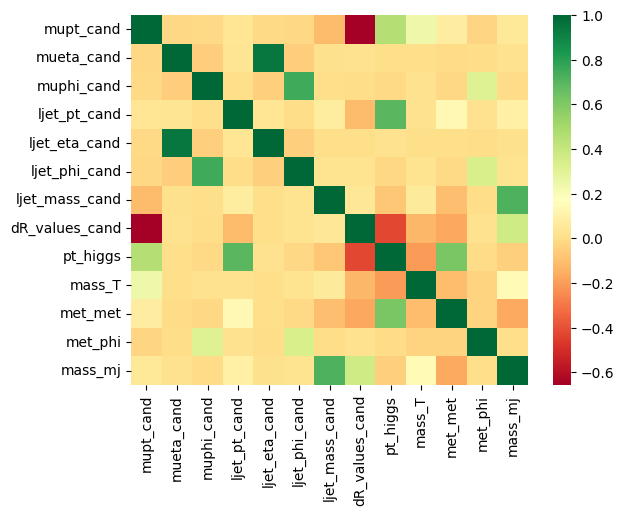

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


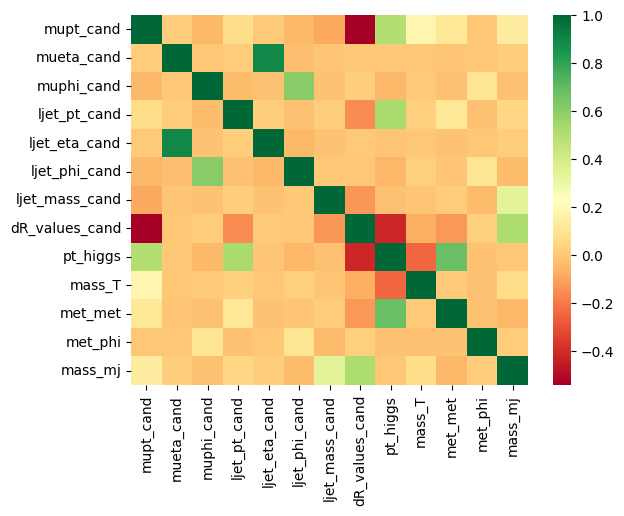

entry
890     0.010185
2324    0.008860
9       0.003796
2140    0.009735
25      0.008696
          ...   
216     0.012322
2093    0.007178
161     0.004859
1495    0.004686
1944    0.006749
Name: weight, Length: 2124, dtype: float64
entry
3386    0.111052
2998    0.133148
2813    0.141820
2401    0.117876
117     0.055638
          ...   
2538    0.109475
622     0.118179
3419    0.102460
1483    0.146624
2670    0.008602
Name: weight, Length: 2259, dtype: float64
Examples:  Total: 4383  Positive: 2124  Negative: 2259  Ratio: 0.48459958932238195
[1 1 1 ... 0 0 0]
[0.01018453 0.00885971 0.00379645 ... 0.10245986 0.14662431 0.00860163]
[242.16090726  14.19429761]
Weighted Training Events:  Total: 256.35520486923275  Positive: 14.194297607802966  Negative: 242.1609072614298  Ratio: 0.055369648589906735
Weighted Test Events:  Total: 80.94767305654634  Positive: 4.466381905527381  Negative: 76.48129115101895  Ratio: 0.05517616179537825
Weighted Validation Events:  Total: 62.6312957991952

In [27]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification', 'mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})

train_df = pd.concat([signal_train_e, ttbar_train_e])
train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])
print(signal_train_weights_e)
print(ttbar_train_weights_e)

test_df = pd.concat([signal_test_e, ttbar_test_e])
test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

val_df = pd.concat([signal_val_e, ttbar_val_e])
val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])

scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
print(train_class)
print(train_weight)
print(np.bincount(train_class, weights=train_weight))
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [28]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [29]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [30]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
nn_model = get_model(METRICS, bias, scaled_train_df)
nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=256, epochs=400, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
# validation_data=(scaled_val_df, val_class),
y_scores = nn_model.predict(scaled_test_df)
nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

Epoch 1/400
16/18 [=========================>....] - ETA: 0s - loss: 0.0902 - tp: 1958.0000 - fp: 2115.0000 - tn: 15.0000 - fn: 8.0000 - accuracy: 0.4817 - precision: 0.4807 - recall: 0.9959 - auc: 0.6012 - prc: 0.5810  
Epoch 1: saving model to checkpoint.ckpt
18/18 [==============================] - 2s 45ms/step - loss: 0.0894 - tp: 2116.0000 - fp: 2243.0000 - tn: 16.0000 - fn: 8.0000 - accuracy: 0.4864 - precision: 0.4854 - recall: 0.9962 - auc: 0.6004 - prc: 0.5854 - val_loss: 0.9640 - val_tp: 528.0000 - val_fp: 558.0000 - val_tn: 7.0000 - val_fn: 3.0000 - val_accuracy: 0.4881 - val_precision: 0.4862 - val_recall: 0.9944 - val_auc: 0.5970 - val_prc: 0.5700
Epoch 2/400
14/18 [======================>.......] - ETA: 0s - loss: 0.0901 - tp: 1722.0000 - fp: 1841.0000 - tn: 14.0000 - fn: 7.0000 - accuracy: 0.4844 - precision: 0.4833 - recall: 0.9960 - auc: 0.6026 - prc: 0.5863     
Epoch 2: saving model to checkpoint.ckpt
18/18 [==============================] - 0s 10ms/step - loss: 0.08

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 56        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
NN AUC:  0.6495809972563522


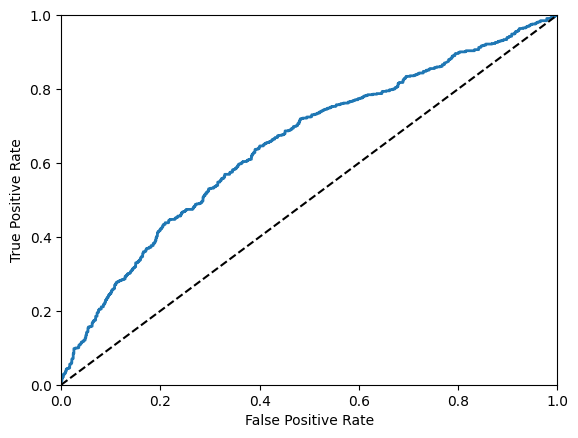

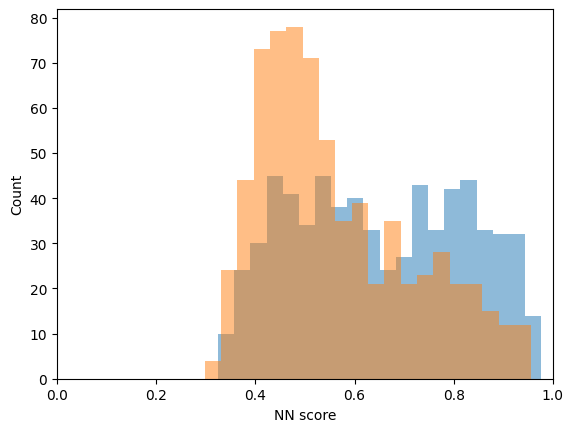

21.626200199127197
23.267338305711746


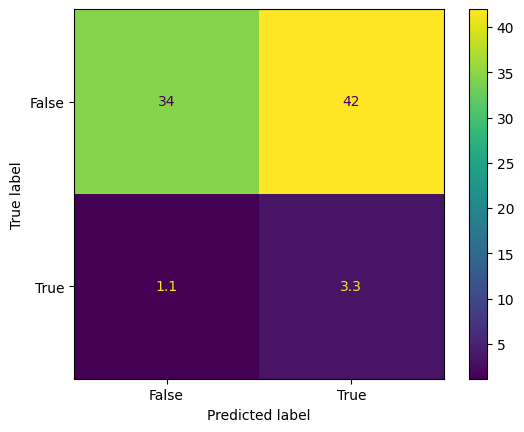

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print("NN AUC: ", auc(nn_fakes, nn_reals))

# nn_loss_plot = plot_loss(nn_fit)
# nn_accuracy_plot = plot_accuracy(nn_fit)

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
# plt.plot(nn_fakes, nn_reals, label="NN")
# plt.legend()
# plt.show()

# , weights=test_weight[test_class == 1]
# , weights=test_weight[test_class == 0]

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=20, alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=20, alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
plt.xlim([0, 1])
# plt.yscale('log')
plt.show()

# plt.hist(nn_signal_scores, bins=20, alpha = 0.5, label='background')
# plt.xlim([0, 1])
# # plt.yscale('log')
# plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [32]:
bdt_model = boosted_decision_tree()

bdt_fit = bdt_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

bdt_y_scores = bdt_model.predict(scaled_test_df)

Use /tmp/tmp85nymve9 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.418977. Found 4383 examples.
Reading validation dataset...


Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.342205. Found 1096 examples.
Training model...


2022-12-05 02:49:45.664889: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1765] Subsample hyperparameter given but sampling method does not match.
2022-12-05 02:49:45.664964: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1778] GOSS alpha hyperparameter given but GOSS is disabled.
2022-12-05 02:49:45.664974: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1787] GOSS beta hyperparameter given but GOSS is disabled.
2022-12-05 02:49:45.664978: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1799] SelGB ratio hyperparameter given but SelGB is disabled.
2022-12-05 02:49:45.665324: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:451] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2022-12-05 02:49:45.665414: I external/ydf/yggdrasil_decision_

Model trained in 0:00:01.306951
Compiling model...


2022-12-05 02:49:46.935796: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1567] Create final snapshot of the model at iteration 82
2022-12-05 02:49:46.941133: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2022-12-05 02:49:46.941743: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:53 valid-loss:0.866528 valid-accuracy:0.805657
[INFO 2022-12-05T02:49:46.959445461-05:00 kernel.cc:1175] Loading model from path /tmp/tmp85nymve9/model/ with prefix 7ff34e1183c9421e
[INFO 2022-12-05T02:49:46.964540104-05:00 abstract_model.cc:1306] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2022-12-05T02:49:46.964570001-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 3ms/step


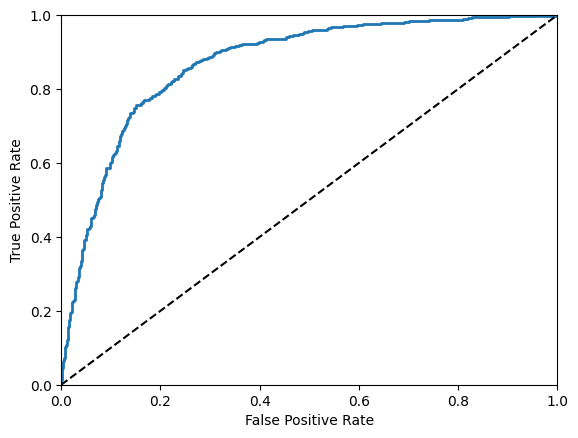

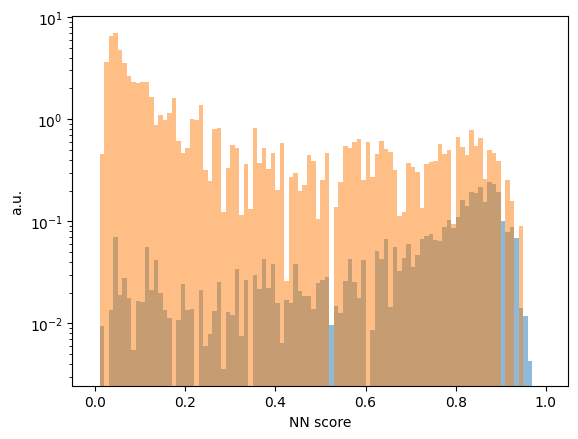

0.044663816018354376
0.7648128881011113


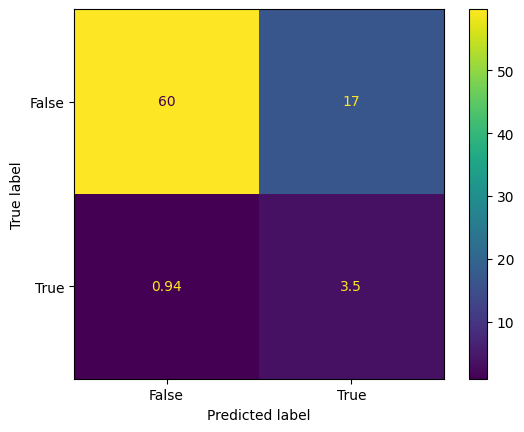

In [57]:
y_pred = np.round(bdt_y_scores)

# bdt_model.summary()

nn_signal_scores = bdt_y_scores[test_class == 1]
nn_background_scores = bdt_y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, bdt_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='signal', weights=test_weight[test_class == 1])
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=100, range=(0,1), alpha = 0.5, label='background', weights=test_weight[test_class == 0])
plt.xlabel('NN score')
plt.ylabel('a.u.')
plt.yscale('log')
plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [34]:
rft_model = random_forest_tree()

rft_fit = rft_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

rft_y_scores = rft_model.predict(scaled_test_df)

Use /tmp/tmphj4qki36 as temporary training directory


Reading training dataset...
Training dataset read in 0:00:01.207236. Found 4383 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.488283. Found 1096 examples.
Training model...


[INFO 2022-12-05T02:49:54.418408673-05:00 kernel.cc:1175] Loading model from path /tmp/tmphj4qki36/model/ with prefix 0b8bfc81852e431a


Model trained in 0:00:02.023652
Compiling model...


[INFO 2022-12-05T02:49:54.994077802-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 6ms/step


Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.   "__LABEL" 10.327272 ################
    2.  "data:0.1"  9.229662 #############
    3.  "data:0.5"  9.223861 #############
    4. "data:0.11"  9.185450 #############
    5.  "data:0.2"  9.128593 #############
    6.  "data:0.4"  9.084181 #############
    7.  "data:0.3"  7.885903 ###########
    8.  "data:0.0"  7.567829 ##########
    9.  "data:0.8"  6.691197 #########
   10.  "data:0.6"  6.638235 #########
   11. "data:0.10"  3.8039

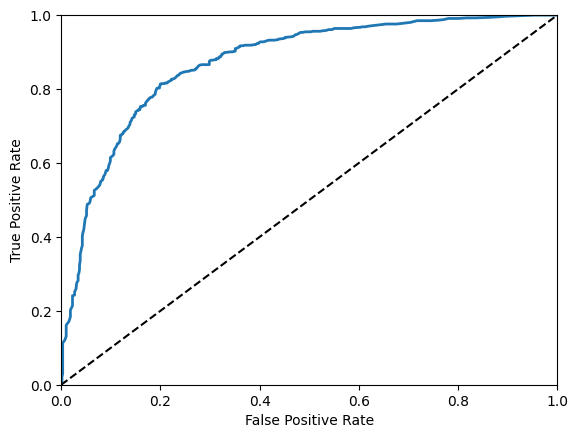

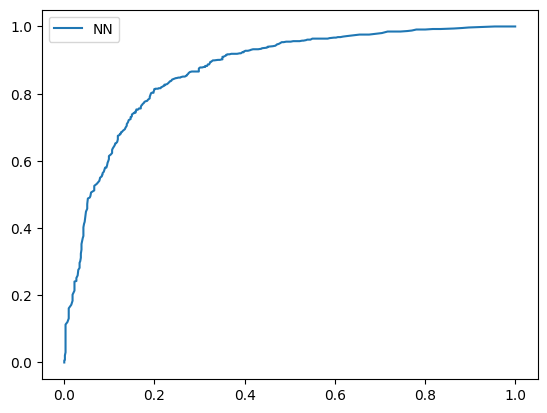

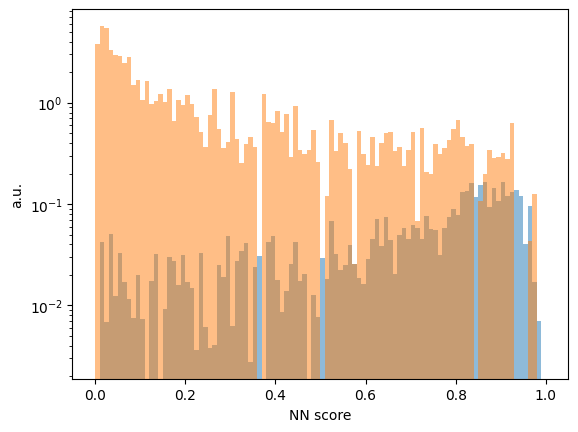

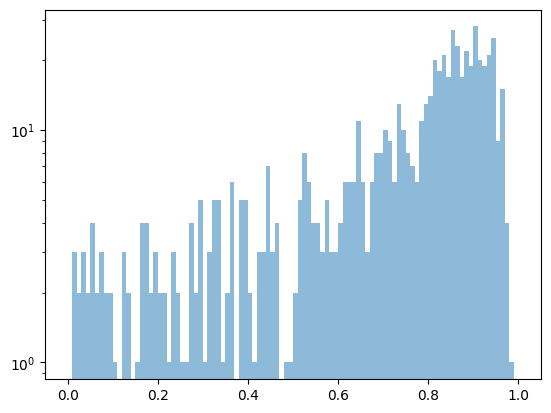

0.04466382262298222
0.7648128853904441


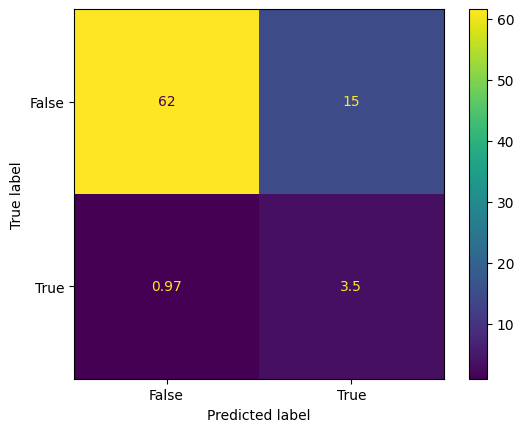

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(rft_y_scores)

rft_model.summary()

nn_signal_scores = rft_y_scores[test_class == 1]
nn_background_scores = rft_y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, rft_y_scores)

print("NN AUC: ", auc(nn_fakes, nn_reals))

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
plt.plot(nn_fakes, nn_reals, label="NN")
plt.legend()
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='signal', weights=test_weight[test_class == 1])
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=100, range=(0,1), alpha = 0.5, label='background', weights=test_weight[test_class == 0])
plt.xlabel('NN score')
plt.ylabel('a.u.')
plt.yscale('log')
plt.show()
plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='background')
plt.yscale('log')
plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()